# Avaliação e Melhoria de Modelos

Uma vez que já finalizamos os fundamentos de algoritmos supervisionados e não-supervisionados, além de ter explorado uma variedade enorme de algoritmos de ML, vamos agora ver como avaliamos as nossas criações, observando seus resultados e selecionando melhores parâmetros.
<br>

Até o momento, nossa validação se reteve à dividir o dataset em `train` e `test` e observar o resultado no test - enquanto treinavamos no train. Vamos relembrar:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

sns.set_context('talk')

In [2]:
# Criando um set sintético
X, y = make_blobs(random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# instanciando e treinando o logreg
logreg = LogisticRegression().fit(X_train, y_train)

# Avaliando o modelo no test set
print(f"Test set score: {logreg.score(X_test, y_test):.2f}")

Test set score: 0.88


Vale relembrar também o motivo dessa divisão. Uma vez apenas treinado em um dataset, nosso modelo estará propenso ao **overfitting**. Ao testar em um set que ainda não foi visto pelo modelo, testamos sua capacidade de generalização para novos casos. 
<br>

Nesse capítulo, estudaremos **Cross-Validation**, um método mais robusto de testar generalização, outras **métricas de avaliação** além da R² e acurácia e, por fim, o **Grid Search**, um método de ajuste de hiperparâmetros. 

## Cross-Validation

O **Cross-Validation**, tabém conhecido apenas como CV ou validação cruzada em PT-BR, é um método estatístico de avaliação de generalização que é mais estável e sólido que o `train_test_split`. Normalmente, é utilizado o `k-fold cross-validation`, que se dá, inicialmente, dividindo o dataset em `k` partes. Em seguida, o modelo é treinado nas partes 2, 3, 4, ..., k e validado na parte 1. O processo se repete para a parte 2, com o modelo sendo treinando na 1, 3, ..., k e validado na 2 - assim por diante até chegar ao k.

Com a finalização do processo, temos k scores diferentes. Abaixo, uma figura que ilustra um 5-fold cross-validation:

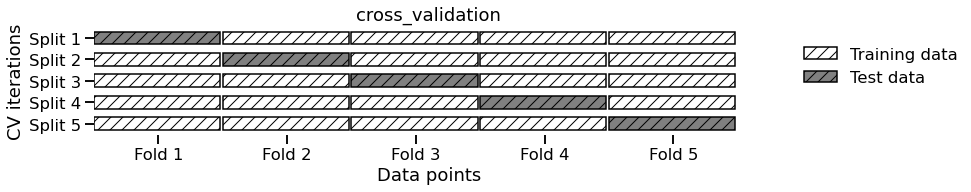

In [3]:
mglearn.plots.plot_cross_validation()

O cross-validation é implementado no `scikit-learn` por padrão, no módulo `model_selection`. Como parâmetros, ele toma o modelo, o dataset de treino, as labels/resultados verdadeiros e `cv` para o número de folds - por padrão, é igual a 5.

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris

# Criando um set iris
iris = load_iris()

# Instancia o Log Reg
logreg = LogisticRegression(max_iter = 2000)

scores = cross_val_score(logreg, iris.data, iris.target)
print(f"Cross-validation scores: {scores}")

Cross-validation scores: [0.96666667 1.         0.93333333 0.96666667 1.        ]


In [5]:
scores = cross_val_score(logreg, iris.data, iris.target, cv = 10)
print(f"Cross-validation scores: {scores}")

Cross-validation scores: [1.         0.93333333 1.         1.         0.93333333 0.93333333
 0.93333333 1.         1.         1.        ]


Como é possível ver acima, há uma certa disparidade entre os resultados - em alguns folds, a acurácia chega em 100% e em outros, próxima de 90%. Isso pode ser tanto devido ao número baixo de observações quanto a necessidade do modelo de visualizar alguma certa parte do dataset para fazer boas previsões.

Para resumir, podemos tirar a média desse score:

In [6]:
print(f"Cross-validation mean score: {np.mean(scores):.2f}")

Cross-validation mean score: 0.97


Vamos pontuar os benefícios e a maior desvantagem de utilizar o CV.

* **Benefícios**:
    * Sem chance de sermos azarados ou sortudos devido à parte aleatória do `train_test_split`
    * O modelo precisa ir bem em todas as partes do dataset para ir bem
    * Utilizamos mais dados para o treino, o que aproxima o score do modelo final
    * Multiplos splits nos mostram o quão o modelo é sensível para novos dados/dados diferentes

* **Desvantagem**:
    * Aumento no custo computacional (até k vezes mais modelos rodados).
    
### Outras opções de Cross-Validation

Vimos aqui que o CV separa o dataset de forma ordenada, da forma que o dataset é dado (fig. 1). Isso nem sempre é uma boa ideia caso os dados estejam ordenados de alguma forma ou caso algumas das labels em um problema de classificação estejam em minoria. Para resolver isso, podemos utilizar o **Stratified k-Fold CV** que, assim como no `train_test_split`, separa o dataset levando em consideração a porcentagem de cada label.

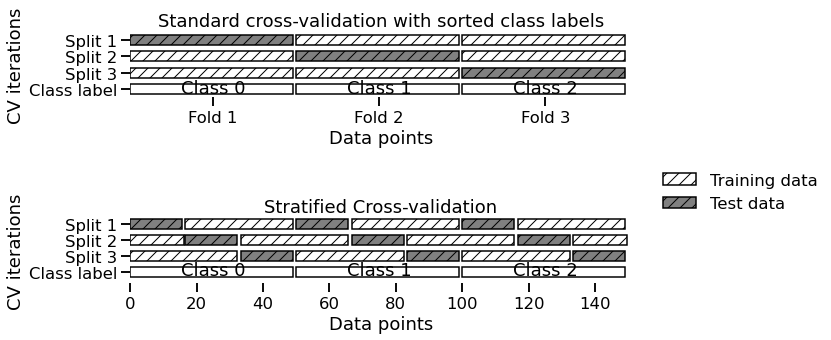

In [7]:
mglearn.plots.plot_stratified_cross_validation()

In [8]:
from sklearn.model_selection import StratifiedKFold

# Instancia o Log Reg
logreg = LogisticRegression(max_iter=2000)

# Instancia o SKF
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(logreg, iris.data, iris.target, cv=skf)
print(f"Cross-validation scores: {scores}")

print(f"Cross-validation mean score: {np.mean(scores):.2f}")

Cross-validation scores: [1.         1.         1.         0.93333333 0.93333333 0.93333333
 1.         1.         0.93333333 0.93333333]
Cross-validation mean score: 0.97


É uma prática extremamente comum utilizar o Stratified k-Fold CV para problemas de classificação, quase que padrão. Já em modelos de regressão, o mais comum é utilizar o k-Fold padrão.

Além do Stratified k-Fold e do k-Fold, temos também opções como o **Leave-One-Out**, **Shuffle-Split** e **Group K-Fold**. O Leave-One-Out é basicamente o k-Fold com k = número de observações. Pode acabar sendo interessante para datasets pequenos, mas em temos de Big Data, se torna absurdamente custoso computacionalmente. 

In [9]:
from sklearn.model_selection import LeaveOneOut

# Instancia o Log Reg
logreg = LogisticRegression(max_iter=2000)

# Instancia o Leave One Out
loo = LeaveOneOut()

scores = cross_val_score(logreg, iris.data, iris.target, cv=loo)

print("Number of cv iterations: ", len(scores))
print(f"Mean accuracy: {scores.mean():.2f}")

Number of cv iterations:  150
Mean accuracy: 0.97


O **Shuffle-Split** oferece maior controle no tamanho dos folds, permitindo que seja escolhido o número de splits e a porcentagem que vai para cada parte - treino e teste.

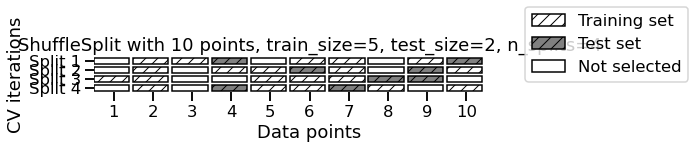

In [10]:
mglearn.plots.plot_shuffle_split()

In [11]:
from sklearn.model_selection import ShuffleSplit

# Instancia o Log Reg
logreg = LogisticRegression(max_iter=2000)

# Instancia o Leave One Out
shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)

scores = cross_val_score(logreg, iris.data, iris.target, cv=shuffle_split)

print("Number of cv iterations: ", len(scores))
print(f"Mean accuracy: {scores.mean():.2f}")

Number of cv iterations:  10
Mean accuracy: 0.96


Uma característica interessante do Shuffle-Split é que a soma da parte do treino e do teste não precisa ser igual a 1, permitindo subsampling para facilitar a experimentação em datasets grandes.
<br>

Por último, o **GroupKFold** é utilizado quando temos grupos nos dados que são relacionados. Por exemplo, se quisermos criar um modelo que detecte uma expressão facial e temos várias fotos de cada pessoa no dataset. O modelo identificará com maior facilidade expressões de pessoas que ele já viu, ou seja, que já estavam no set de treino. 

A ideia é basicamente o oposto do Stratified - treinamos em um ou mais grupos e buscamos pela generalização em grupos ainda não vistos.

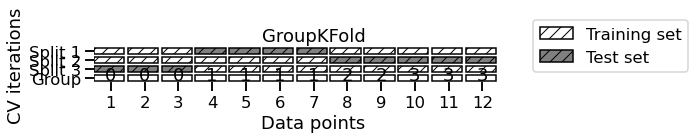

In [12]:
mglearn.plots.plot_group_kfold()

In [13]:
from sklearn.model_selection import GroupKFold

# Criando um set sintético

X, y = make_blobs(n_samples=12, random_state=0)

# os primeirs 3 pertencem a um grupo, depois os próximos quatro, os próximos 2 etc.

groups = [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3]
scores = cross_val_score(logreg, X, y, groups, cv=GroupKFold(n_splits=4))

print(f"Cross-validation scores:\n{scores}")

Cross-validation scores:
[0.75       0.66666667 0.66666667 1.        ]


Existem outras formas e estratégias de realizar a validação cruxada no scikit-learn - elas estão presentes [nessa parte da documentação](https://scikit-learn.org/stable/modules/cross_validation.html). No entanto, as que vimos nesse notebook são as mais utilizadas! 
<br>

## Grid Search

Uma vez sabendo como avaliar a generalização do modelo e conhecendo os hiperparâmetros do algoritmo utilizado ([ver capítulo 2](https://github.com/nicolasbuen/introduction_to_ml)), está na hora de melhorar a perfomance do modelo ajustando eles.
<br>

Uma das formas mais comuns - e incluídas por padrão no scikit-learn - é o *grid search*, que basicamente testa todos as combinações possíveis dos parâmetros interessados. Se quisessemos procurar os melhores valores para os hiperparametros do SVC c/ kernel RBF: 

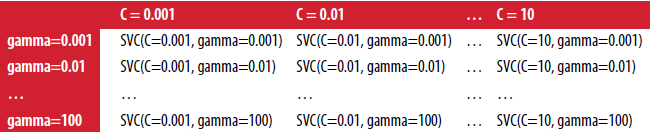

A implementação correta da hiperparametrização deve dividir o dataset em 3:

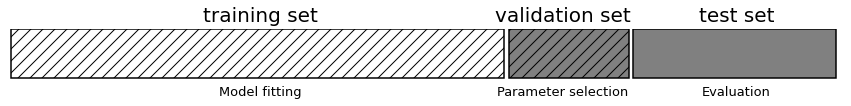

In [14]:
mglearn.plots.plot_threefold_split()

Dessa forma, evitamos overfitting apenas no set de treino, podendo testar a capacidade de generalização em um set nunca visto antes.


In [15]:
from sklearn.svm import SVC

# separar os dados em 2 sets
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data,
                                                          iris.target,
                                                          random_state=0)

# sseparar o trainval em 2
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval,
                                                      random_state=1)

print(f"""Size of training set: {X_train.shape[0]},
\nsize of validation set: {X_valid.shape[0]},
size of test set: {X_test.shape[0]}""")

best_score = 0

# implmementando o gs manualmente
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        
# instancia o SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        
        # avalia o svc
        score = svm.score(X_valid, y_valid)
        
        # se score >, atualiza os melhores parametros e score 
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
            
# treina o modelo no trainval com os melhores parametros e testa
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

test_score = svm.score(X_test, y_test)
print(f"\nBest score on validation set: {best_score:.2f}".format(best_score))
print(f"Best parameters: {best_parameters}")
print(f"\nTest set score with best parameters: {test_score:.2f}")

Size of training set: 84,

size of validation set: 28,
size of test set: 38

Best score on validation set: 0.96
Best parameters: {'C': 10, 'gamma': 0.001}

Test set score with best parameters: 0.92


Conseguimos um score de 0.96 no set de validação e 0.92 no de teste, mesmo que o último modelo tenha sido treinado com mais dados. Isso ocorre porque os parâmetros foram definidos de acordo com o teste de validação. 
<br>

Para aplicar Machine Learning em problemas reais e práticos, devemos tomar cuidado com qualquer "vazamento" de dado em um set de teste, seja a hiperparametrização ou até decisões baseadas na exploração dos dados (EDA). Somente assim teremos um resultado mais realista sobre o desempenho real do modelo.

### Grid Search c/ CV

O problema visto antes nesse notebook durante a discussão da validação cruzada continua aqui - essa hiperparametrização acaba sendo sensível a forma que o dataset está ordenado. Ao invés de treinar e validar apenas em um set, podemos fazer isso em CV. 

In [16]:
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    
        # instancia o cv com os parametros
        svm = SVC(gamma=gamma, C=C)

        # avalia no cv
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)

        # calcula a media 
        score = np.mean(scores)

        # se score >, atualiza os melhores parametros e score 
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
        
# treina o modelo no trainval com os melhores parametros e testa
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

test_score = svm.score(X_test, y_test)

print(f"\nBest score on validation set: {best_score:.2f}".format(best_score))
print(f"Best parameters: {best_parameters}")
print(f"\nTest set score with best parameters: {test_score:.2f}")


Best score on validation set: 0.97
Best parameters: {'C': 10, 'gamma': 0.1}

Test set score with best parameters: 0.97


Utilizar o CV para a escolha dos hiperparametros resultou em um modelo mais generalizavel - no entanto, multiplicamos em 5 o número de iterações e consequentemente, o custo computacional dessa hiperparametrização.
<br>

Como o Grid Search em conjunto com o CV é uma task comum de se realizar, o scikit-learn oferece ele em forma de uma classe - `GridSearchCV()`, que leva como argumentos o grid de hiperparâmetros, o modelo e o número de splits (ou o método do split) do CV. 

In [17]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(SVC(), param_grid, cv=5)

X_train, X_test, y_train, y_test = train_test_split(iris.data,
                                                    iris.target,
                                                    random_state=0)
grid_search.fit(X_train, y_train)

print(f"Test set score: {grid_search.score(X_test, y_test):.2f}")
print(f"Best parameters: {grid_search.best_params_}")

Test set score: 0.97
Best parameters: {'C': 10, 'gamma': 0.1}


Como esperado, o resultado é o mesmo pro score e pros parâmetros escolhidos. Podemos também acessar o modelo completo utilizando o atributo `.best_estimator_`

In [18]:
grid_search.best_estimator_

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

O GridSearchCV também permite uma análise mais aprofundada dos resultados de cada hiperparâmetro. Isso é interessante uma vez que um GridSearch extenso pode ser bem custoso computacionalmente - ao achar um range de parâmetros melhores, podemos recriar um Grid mais focado num range menor, mas mais expandido.

In [19]:
results = pd.DataFrame(grid_search.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.0004,0.00049,0.0004,0.00049,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
1,0.0004,0.00049,0.0000,0.00000,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
2,0.0004,0.00049,0.0000,0.00000,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
3,0.0002,0.00040,0.0002,0.00040,0.001,1,"{'C': 0.001, 'gamma': 1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
4,0.0002,0.00040,0.0002,0.00040,0.001,10,"{'C': 0.001, 'gamma': 10}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
5,0.0006,0.00049,0.0000,0.00000,0.001,100,"{'C': 0.001, 'gamma': 100}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
6,0.0004,0.00049,0.0004,0.00049,0.01,0.001,"{'C': 0.01, 'gamma': 0.001}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
7,0.0004,0.00049,0.0000,0.00000,0.01,0.01,"{'C': 0.01, 'gamma': 0.01}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
8,0.0002,0.00040,0.0002,0.00040,0.01,0.1,"{'C': 0.01, 'gamma': 0.1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
9,0.0002,0.00040,0.0002,0.00040,0.01,1,"{'C': 0.01, 'gamma': 1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22


Cada row tem um modelo treinado, com os hiperparametros, dados sobre o tempo de treinamento e o score em cada set. Para visualizar melhor os resultados dos hiperparâmetros em relação ao score, vamos utilizar um heatmap: 

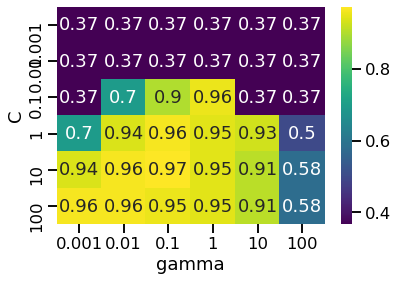

In [20]:
scores = np.array(results.mean_test_score).reshape(6, 6)

# plot the mean cross-validation scores

ax = sns.heatmap(scores, cmap="viridis", annot=True)

ax.set(xticklabels=param_grid['gamma'],
       ylabel='C',
       yticklabels=param_grid['C'],
       xlabel='gamma');

Pelo resultado, dá pra perceber que a escolha dos hiperparâmetros importa e MUITO para o resultado - temos alguns scores abaixo de 0.4. Além disso, dá pra ver que o range do grid escolhido foi bom, uma vez que o melhor resultado não está em nenhum dos cantos.

O GridSearchCV também permite uma lista de grids - dessa forma, podemos testar hiperparâmetros dependentes de outros. No SVC,  por exemplo, caso utilizassemos kernel linear ao invés de RBF, o gamma não faria sentido algum.

In [21]:
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f"Test set score: {grid_search.score(X_test, y_test):.2f}")
print(f"Best parameters: {grid_search.best_params_}")

Test set score: 0.97
Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


Podemos ir ainda mais fundo que a validação cruzada dentro do GridSearch e implementá-la dentro do cross_val_score - isso garante que nosso modelo treine em diferentes partes do dataset, sem se prender a somente um mas também sem ter um vazamento de dados real. No entanto, isso é pouquíssimo usado para previsões, mais para verificar o quão bem o modelo pode ir em um dataset: 

In [22]:
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5),
                         iris.data, iris.target, cv=5)

print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.96666667 1.         0.9        0.96666667 1.        ]
Mean cross-validation score:  0.9666666666666668


Como realizamos a validação cruzada duas vezes, nosso modelo acabou sendo treinado 900 vezes. O dataset iris é simples e o SVC é um modelo relativamente leve computacionalmente, mas algoritmos como o nested loop podem acabar se tornando bem pesados em Gradient Boosting Machines.
<br>

## Métricas de Avaliação

Até o momento, o livro só abordou acurácia e R². No entanto, são infinitas as possibilidades de métricas para a otimização, e devemos defini-las de acordo com o objetivo final do modelo. Qual é a métrica de negócio a ser alcançada? O que o algoritmo tem que priorizar acertar? Quais erros seriam os "menos piores"?

### Métricas para Classificação Binária

Vamos aos fatos - acurácia nem sempre é uma boa métrica e é muito fácil de provar isso. Vamos supor que teu modelo serve pra prevê a existência de uma doença extremamente rara e mortal, com 0.5% de chance de ocorrer dentro da amostra. Se teu modelo é simplesmente afirmar que a doença não existe e retornar 0 (negativo) para todos os exames, ele terá a acurácia de 99.5%... o que, na teoria, é um baita score. Mas e na prática? Nesse caso, seria mais interessante ter falsos positivos do que falsos negativos, dada a gravidade da doença.

Em estatística, os FPs (falso positivos) são chamados de erro do Tipo I. Já os FNs (falso negativos) são chamados de Tipo II. Eu prefiro os termos FP e FNs do que os termos estatísticos - eles são mais explicítos e mais fáceis de entender.

* A **acurácia** é definida por (TP + TN)/(Todas Samples) - ou seja, o número de acertos pelo número de amostras. 
* A **precisão**, que é definida por TP/(TP + FP) - ela é utilizada quando a ideia é reduzir o número de Falso Positivos. 
* O **recall** é o contrário da precisão: TP/(TP + FN), e é usado para reduzir o número de Falso Negativos. O exemplo da doença rara e mortal que foi dado acima é um dos problemas que se beneficiaria fortemente do uso do recall. Ele também é chamado de sensibilidade.

Por fim, temos o **F-Score**. Ele tenta balancear a precisão e o recall utilizando a seguinte formula: 
* $F = 2 * \frac{precision*recall}{precision + recall}$ 

Essa formula em especifíco se refere ao F1-score, o mais utilizado entre eles. Existem outros de acordo com a importância dada ao recall. O seu problema é que é mais complexo de interpretar e de explicar para aqueles de fora da área.

______

#### Mudando o threshold em problemas de classificação

Alguns algoritmos classificatórios do scikit-learn permitem alterar o threshold da decisão - aumentar ou reduzir a certeza necessária que o modelo tem que ter para marcar uma observação como positiva. Reduzir o threshold do padrão (0) para -0.8, por exemplo, aumentaria o recall e reduziria a precisão, uma vez que seriam menores os números de Falso Negativos pois o modelo definiria como positivos mais observações.  

In [23]:
# Treinando um svc padrão

from mglearn.datasets import make_blobs
from sklearn.metrics import classification_report

X, y = make_blobs(n_samples=(400, 50),
                  centers=2,
                  cluster_std=[7.0, 2],
                  random_state=22)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

svc = SVC(gamma=.05).fit(X_train, y_train)

print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       104
           1       0.35      0.67      0.46         9

    accuracy                           0.88       113
   macro avg       0.66      0.78      0.70       113
weighted avg       0.92      0.88      0.89       113



C:\Users\bueni\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=FutureWarning)


In [24]:
# Reduzindo o threshold de decisão

y_pred_lower_threshold = svc.decision_function(X_test) > -0.8

print(classification_report(y_test, y_pred_lower_threshold))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       104
           1       0.32      1.00      0.49         9

    accuracy                           0.83       113
   macro avg       0.66      0.91      0.69       113
weighted avg       0.95      0.83      0.87       113



In [25]:
# Aumentando o threshold de decisão

y_pred_higher_threshold = svc.decision_function(X_test) > 0.8

print(classification_report(y_test, y_pred_higher_threshold))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       104
           1       0.50      0.44      0.47         9

    accuracy                           0.92       113
   macro avg       0.73      0.70      0.71       113
weighted avg       0.92      0.92      0.92       113



Ao aumentar o threshold, obrigamos o modelo a ter maior certeza antes de prever alguém como positivo - isso reduz o número de Falso Positivos, mas também aumenta o número de FNs. A decisão deve ser feita de acordo com a necessidade do negócio e/ou do problema.

Vale lembrar que assim como a hiperparametrização, a escolha do threshold deve ser feita em um set de validação e não no set de teste, de forma a obter um resultado não otimista para o problema real.

<br>

Além do `decision_function`, outros modelos utilizam o método `predict_proba` (como é o caso dos ensembles), que retorna a probabilidade de 0 - 1 para a classe positiva. Por padrão, o modelo define 0.5 como o threshold, ou seja, caso ele tenha <= 50% de certeza que aquela é a classe certa, ele irá prever ela. 

A predict_proba tem relação com o conceito de calibração de modelos. Um modelo definido como calibrado tem sua incerteza precisa - e podemos criar valor a partir das suas certezas e incertezas. As autoras do livro recomendam um [artigo chamado "“Predicting Good Probabilities with Supervised Learning”](https://www.cs.cornell.edu/~alexn/papers/calibration.icml05.crc.rev3.pdf), que cobre o assunto com mais detalhe.

### Curva precision-recall e ROC 

Ali em cima a gente viu que sempre é possível chegar em uma certa precisão ou certo recall, o problema é a troca que estaremos fazendo. Se rotular todo mundo positivo, teremos o recall perfeito mas uma precisão igual zero. Para que seja possível ter uma ideia geral de qual o threshold de score que queremos alcançar sem ter que perder muito de algum dos lados, podemos utilizar a ferramente `curva precision-recall`, disponível no módulo de métricas do scikit-learn. 

Para demonstrar, vamos utilizar um dataset novo com maior número de datapoints (permitindo um gráfico mais suave).

In [26]:
X, y = make_blobs(n_samples=(4000, 500),
                  centers=2,
                  cluster_std=[7.0, 2],
                  random_state=22)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

svc = SVC(gamma=.05).fit(X_train, y_train)

C:\Users\bueni\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=FutureWarning)


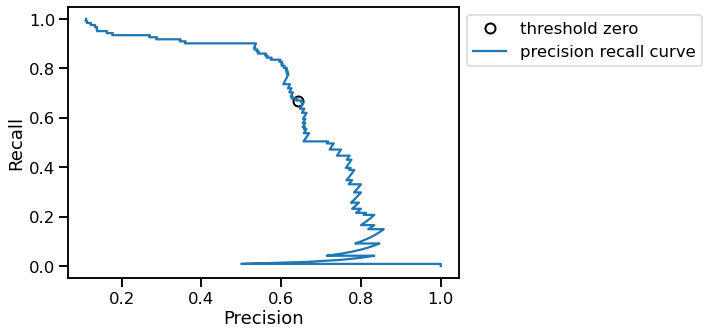

In [27]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))

close_zero = np.argmin(np.abs(thresholds))

fig, ax = plt.subplots(figsize=(7,5))

ax = plt.plot(precision[close_zero], recall[close_zero],
         'o', markersize=10, label="threshold zero",
         fillstyle="none", c='k', mew=2)

ax = plt.plot(precision, recall, label="precision recall curve")
ax = plt.xlabel("Precision")
ax = plt.ylabel("Recall")
ax = plt.legend(bbox_to_anchor = (1, 1))
sns.set_context('talk')

No ponto 0, está o threshold padrão da `decision_function` do SVC - aproximadamente 0.65 de recall e de precisão. Cada um dos pontos da linha corresponde a uma possibilidade de threshold da decision_function. Também é possível ver que com um recall próximo do 0.5, podemos chegar em uma precisão de 0.75. 
<br>

Quanto mais próximo essa curva estivar to topo direito, melhor o classificador (recall e precisão alta). Dá pra ver certinho o efeito que havíamos discutido antes: recall máximo -> precisão miníma e vice-versa. Nesse modelo em especifíco, podemos ver que até 0.5 de precisão, aumentar ela não tem muito custo de recall (a curva é quase reta na parte de cima). No entanto, após o 0.5 de precisão, cada aumento gera um custo de recall altíssimo, com uma queda brusca para chegar ao 0.7, por exemplo.
<br>

Vamos realizar essa curva para um segundo modelo:

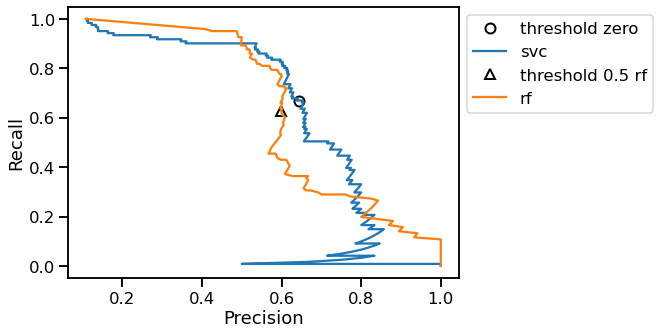

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100,
                            random_state=0,
                            max_features=2).fit(X_train, y_train)

rf_precision, rf_recall, rf_thresholds = precision_recall_curve(y_test, rf.predict_proba(X_test)[:, 1])

# Ajustando o argmin para o predict_proba
rf_close_zero = np.argmin(np.abs(rf_thresholds - 0.5))

fig, ax = plt.subplots(figsize=(7,5))

# Curva pr para svc
ax = plt.plot(precision[close_zero], recall[close_zero],
         'o', markersize=10, label="threshold zero",
         fillstyle="none", c='k', mew=2)

ax = plt.plot(precision, recall, label="svc")

# Curva pr para rf
ax = plt.plot(rf_precision[rf_close_zero], rf_recall[rf_close_zero],
              '^', markersize=10, label="threshold 0.5 rf",
              fillstyle="none", c='k', mew=2)

ax = plt.plot(rf_precision, rf_recall, label="rf")

ax = plt.xlabel("Precision")
ax = plt.ylabel("Recall")
ax = plt.legend(bbox_to_anchor = (1, 1))

O SVC funciona melhor no meio enquanto o RandomForest classifica melhor em valores extremos (Precisão ou Recall ~ 1). No geral, podemos considerar que o SVC é um modelo melhor e a métrica F-score, mas dependendo do problema o RF poderia ser mais útil.

In [29]:
from sklearn.metrics import f1_score

print(f"RF F1: {f1_score(y_test, rf.predict(X_test)):.3f}")

print(f"SVC F1: {f1_score(y_test, svc.predict(X_test)):.3f}")

RF F1: 0.610
SVC F1: 0.656


Comparar a curva PR-REC entre modelos pode gerar alguns insights detalhados, mas é um processo bem manual. Podemos reduzir as curvas a uma comparação entre a área abaixo delas - com a métrica chamada PR AUC. Ela está disponível como `average_precision_score` no módulo de métricas do scikit-learn e recebe os métodos `predict_proba` e `decision_function` para que seja possível comparar múltiplos thresholds.

In [30]:
from sklearn.metrics import average_precision_score

ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:, 1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))

print(f"Average precision of random forest: {ap_rf:.3f}")
print(f"Average precision of svc: {ap_svc:.3f}")

Average precision of random forest: 0.660
Average precision of svc: 0.666


Antes de entrar nas métricas para classificação multiclasse, tem mais uma ferramenta que é usada comumente para analisar o comportamento de classifcadores em diferentes thresholds: a curva ROC, sigla para receiver operating characteristics curve. Ela funciona de forma parecida à curva PR, mas ao invés de ser recall x precisão, é recall x False Positive Rate.

FPR = $\frac{FP}{FP + TN}$

o FPR basicamente é a frequência de Falso Positivos entre todos os negativos da amostra (Falso Positivos + Negativos Verdadeiros). Assim como as outras métricas, ela também está disponível no mesmo módulo do sklearn.

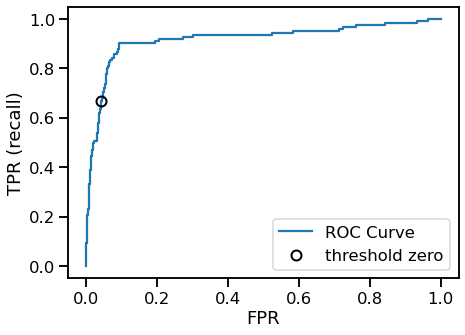

In [31]:
from sklearn.metrics import roc_curve

fig, ax = plt.subplots(figsize=(7,5))

fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))
ax = plt.plot(fpr, tpr, label="ROC Curve")
ax = plt.xlabel("FPR")
ax = plt.ylabel("TPR (recall)")

# find threshold closest to zero

close_zero = np.argmin(np.abs(thresholds))
ax = plt.plot(fpr[close_zero], tpr[close_zero], 'o',
              markersize=10, label="threshold zero",
              fillstyle="none", c='k', mew=2)

ax = plt.legend(loc=4);

Ao contrário da curva PR, a ROC tem seu melhor modelo quanto mais próximo do topo esquerdo: queremos um modelo com um alto recall (baixo número de Falso Negativos) e um baixo FPR (baixo número de Falso Positivos).

No exemplo acima, podemos ver que é possível obter um recall mudando o threshold um pouco, sem aumentar muito o FPR. A partir de um certo ponto, para aumentar um pouquinho o recall seria necessário aumentar MUITO o FPR.

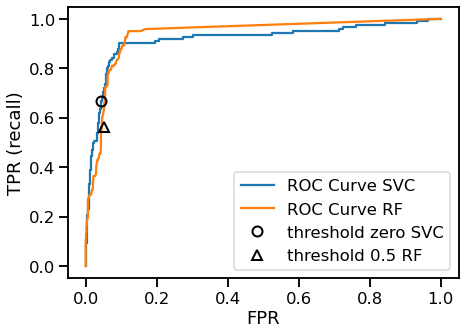

In [32]:
fig, ax = plt.subplots(figsize=(7,5))

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

ax = plt.plot(fpr, tpr, label="ROC Curve SVC")
ax = plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

ax = plt.plot(fpr[close_zero], tpr[close_zero],
              'o', markersize=10,
              label="threshold zero SVC",
              fillstyle="none", c='k', mew=2)

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))

ax = plt.plot(fpr_rf[close_default_rf], tpr[close_default_rf],
              '^', markersize=10,
              label="threshold 0.5 RF",
              fillstyle="none", c='k', mew=2)

ax = plt.legend(loc=4);

Assim como fizemos com o PR, também é possível calcular a área debaixo da curva ROC e ter uma métrica numérica para a curva:{

In [33]:
from sklearn.metrics import roc_auc_score

roc_auc_rf = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc_svc = roc_auc_score(y_test, svc.decision_function(X_test))

print(f"ROC AUC of random forest: {roc_auc_rf:.3f}")
print(f"ROC AUC of svc: {roc_auc_svc:.3f}")

ROC AUC of random forest: 0.937
ROC AUC of svc: 0.916


Por causa das métricas utilizadas para o cálculo da ROC AUC, ela é muito recomendada para avaliar modelos em datasets com labels desbalanceados. Vale lembrar que a AUC não reconhece o threshold padrão mas sim testa os thresholds possíveis. Ela deve ser combinada com uma análise para decidir o melhor threshold para o problema. 

### Métricas para Classificação Multi-Classe

Simplificando, elas são as mesmas que aquelas de classificação binária, mas tirando a média para o número de classes. Os problemas de balanceamento de classes continuam os mesmos (ex.: acurácia ser ruim para datasets desbalanceados) e etc.

Vamos utilizar o dataset digits do sklearn -  contendo imagens de números escritos a mão p/ classificação (1-9) - para analisar as diferenças entre as métricas:

In [34]:
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score, confusion_matrix

digits = load_digits()

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target,
                                                    random_state=0)
lr = LogisticRegression(max_iter = 2000).fit(X_train, y_train)
pred = lr.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, pred):.3f}")
print(f"Confusion matrix:\n{confusion_matrix(y_test, pred)}")

Accuracy: 0.953
Confusion matrix:
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  2  1]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  0 44  0  0  0  0  1  0]
 [ 0  0  0  0 37  0  0  1  0  0]
 [ 0  0  0  0  0 46  0  0  0  2]
 [ 0  1  0  0  0  0 51  0  0  0]
 [ 0  0  0  1  1  0  0 46  0  0]
 [ 0  3  1  0  0  0  1  0 43  0]
 [ 0  0  0  0  0  1  0  0  2 44]]


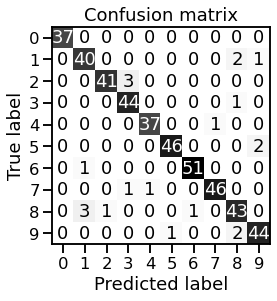

In [35]:
scores_image = mglearn.tools.heatmap(confusion_matrix(y_test, pred),
                                     xlabel='Predicted label', ylabel='True label',
                                     xticklabels=digits.target_names,
                                     yticklabels=digits.target_names,
                                     cmap=plt.cm.gray_r, fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

In [36]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.91      0.93      0.92        43
           2       0.98      0.93      0.95        44
           3       0.92      0.98      0.95        45
           4       0.97      0.97      0.97        38
           5       0.98      0.96      0.97        48
           6       0.98      0.98      0.98        52
           7       0.98      0.96      0.97        48
           8       0.90      0.90      0.90        48
           9       0.94      0.94      0.94        47

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



De acordo com o score, nosso modelo tem acurácia de 95.3% - o que já nos diz que o modelo está indo bem, considerando que nenhuma classe é muito desbalanceada.
<br>

Utilizando a matriz de confusão, vemos que o 0 foi classificado perfeitamente: todos os 0s foram classificados como 0 e nenhum outro número foi confundido pelo nosso modelo como 0. Isso explica a precisão, o recall e, consequentemente, o f1-score da classe 0 ser igual à 1. Já o número 8, por exemplo, foi classificado errado mais vezes. Nosso modelo classificou algumas das amostras como 1, como 2 e como 6. Além disso, ele também confundiu amostras de outros números e classificou eles como 8 - o que reduziu o recall e a precisão.
<br>

Para datasets multiclasse com labels desbalanceadas, a recomendação é utilizar a versão multiclasse do f-score. A ideia por trás dessa versão é calcular o f-score de forma binária para cada classe (mesma ideia da logreg one-vs-all) e depois tirar a média utilizando uma das estratégias abaixo:

* **"macro"**: a média é computada de forma comum, sem ponderação entre as classes.
* **"weighted"**: calcula a média ponderada de acordo com o número de samples em cada classe (support no classification report)
* **"micro**: computa o total de FPs, FNs, e TPs em todas as classes e com isso calucla a precisão, o recall e o f-score utilizando as contagens.

Se a importância maior é a igualdade entre samples, a recomendação é utilizar a média "micro". Para a igualdade entre classes, é recomendado usar a média "macro".

In [37]:
print(f"Micro average f1 score: {(f1_score(y_test, pred, average='micro')):.3f}")

print(f"Macro average f1 score: {(f1_score(y_test, pred, average='macro')):.3f}")

Micro average f1 score: 0.953
Macro average f1 score: 0.954


Infelizmente, as autoras não cobriram quase nada sobre métricas para regressão. Apenas afiramram que a avaliação é feita de forma parecida com a classificação e que para a maioria dos problemas, o uso de R² é suficiente - podendo ser trocada para MAE ou MSE em casos onde decisões de negócio são feitas a partir dessas métricas.

## Utilizando as Métricas para Seleção do Modelo

Um dos parâmetros do GridSearch e da validação cruzada que foi deixado para o final é o `scoring`, que define qual é a métrica utilizada para a seleção do melhor set de hiperparâmetros. Por padrão, é utilizado a acurácia para classificação e o R² para regressão, mas podemos troca-los para qualquer que seja o ideal dependendo do problema:

In [38]:
# Por padrão, a acurácia é selecionada
accuracy = cross_val_score(SVC(), digits.data, digits.target == 9)
print(f"Default scoring: {accuracy}")

# Selecionando o roc_auc
roc_auc = cross_val_score(SVC(), digits.data,
                          digits.target == 9, scoring="roc_auc")

print(f"AUC scoring: {roc_auc}")

Default scoring: [0.975      0.99166667 1.         0.99442897 0.98050139]
AUC scoring: [0.99717078 0.99854252 1.         0.999828   0.98400413]


Podemos fazer a mesma coisa no GridSearchCV:

In [39]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target == 9,
                                                    random_state=0)

param_grid = {'gamma': [0.0001, 0.01, 0.1, 1, 10]}

# Usando o scoring padrão - acurácia
grid = GridSearchCV(SVC(), param_grid=param_grid)
grid.fit(X_train, y_train)

print("Grid-Search with accuracy")
print("Best parameters:", grid.best_params_)
print(f"Best cross-validation score (accuracy)): {grid.best_score_:.3f}".format())

roc_auc = roc_auc_score(y_test, grid.decision_function(X_test))
print(f"Test set AUC: {roc_auc:.3f}")

accuracy = accuracy_score(y_test, grid.predict(X_test))
print(f"Test set accuracy: {accuracy:.3f}")

Grid-Search with accuracy
Best parameters: {'gamma': 0.0001}
Best cross-validation score (accuracy)): 0.976
Test set AUC: 0.992
Test set accuracy: 0.973


In [40]:
# Usando o scoring padrão - acurácia
grid = GridSearchCV(SVC(), param_grid=param_grid, scoring="roc_auc")
grid.fit(X_train, y_train)

print("Grid-Search with ROC AUC")
print("Best parameters:", grid.best_params_)
print(f"Best cross-validation score (AUC): {grid.best_score_:.3f}".format())

roc_auc = roc_auc_score(y_test, grid.decision_function(X_test))
print(f"Test set AUC: {roc_auc:.3f}")

accuracy = accuracy_score(y_test, grid.predict(X_test))
print(f"Test set accuracy: {accuracy:.3f}")

Grid-Search with ROC AUC
Best parameters: {'gamma': 0.01}
Best cross-validation score (AUC): 0.998
Test set AUC: 1.000
Test set accuracy: 0.896


Note como além dos scores diferentes sendo selecionados, o GridSearch também selecionou parâmetros diferentes. Podemos ver todas as possibilidades do scoring utilizando o dicionário `scorer`, também no módulo metrics:

In [41]:
from sklearn.metrics.scorer import SCORERS

SCORERS

C:\Users\bueni\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


{'explained_variance': make_scorer(explained_variance_score),
 'r2': make_scorer(r2_score),
 'max_error': make_scorer(max_error, greater_is_better=False),
 'neg_median_absolute_error': make_scorer(median_absolute_error, greater_is_better=False),
 'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
 'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
 'neg_mean_squared_log_error': make_scorer(mean_squared_log_error, greater_is_better=False),
 'neg_root_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False, squared=False),
 'neg_mean_poisson_deviance': make_scorer(mean_poisson_deviance, greater_is_better=False),
 'neg_mean_gamma_deviance': make_scorer(mean_gamma_deviance, greater_is_better=False),
 'accuracy': make_scorer(accuracy_score),
 'roc_auc': make_scorer(roc_auc_score, needs_threshold=True),
 'roc_auc_ovr': make_scorer(roc_auc_score, needs_proba=True, multi_class=ovr),
 'roc_auc_ovo': make_sc

## Sumário e Conclusão

No capítulo 5, foi discutido métodos de validação cruzada, hiperparametrização através do GridSearch e métricas de avaliação - tudo isso para melhorar os modelos discutidos nos capítulos 2 e 3. Entre os pontos tratados, foi dada muita importância para a forma correta de avaliação de modelos para aplicações reais (utilizando um set de testes completamente separado) e o uso de métricas válidas para o problema do negócio. Na minha opinião, faltou um pouco de atenção às principais métricas de regressão, que não foram tratadas no capítulo.